# Atmospheric Correction (AC) for Remotely sensed Optical imagery : Using Radiative Transfer

For Remotely Sensed Optical (Multispectral/Hyperspectral) Images, The sensor acquired radiance (L) needs to be corrected for the 1. Atmoshperic gaseous transmittance (τ<sub>g</sub>), 2. Rayleigh-aerosol combined scattering in the atmoshperic column (Path radiance; L<sub>p</sub>) to calculate the surface reflectance (ρ). The theory of Radiave Transfer can be used in following way to algebrically express these quantities:

### ρ = π(L -L<sub>p</sub>) / τ<sub>g</sub>(E<sub>dir</sub> + E<sub>dif</sub>)

where
* ρ = surface reflectance
* L = at-sensor radiance
* L<sub>p</sub> = path radiance (Rayeligh + Aerosol)
* τ<sub>g</sub> = gaseous transmissivity (from surface to satellite)
* E<sub>dir</sub> = direct solar irradiance 
* E<sub>dif</sub> = diffuse solar irradiance
* π = 3.1415 (pi)

### 1. Initialization

#### 1.1 Loading dependencies

In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
from Py6S import *
import datetime
import math
import os
import sys
import atmos
from datetime import datetime, timedelta
import act
import ee
import os
import sys
import matplotlib.pyplot as plt
import rasterio
sys.path.append(os.path.join(os.path.dirname(os.getcwd()),'bin'))
from interpolated_LUTs import *
from interpolated_LUTs import Interpolated_LUTs

In [2]:
from dask.distributed import Client, progress
client = Client()  # set up local cluster on the machine
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /notebook/kubeflow-admin-user/analytics-ready-data-gen/proxy/127.0.0.1:8787/status,
Dashboard: /notebook/kubeflow-admin-user/analytics-ready-data-gen/proxy/127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34885,Workers: 4
Dashboard: /notebook/kubeflow-admin-user/analytics-ready-data-gen/proxy/127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:36651,Total threads: 2
Dashboard: /notebook/kubeflow-admin-user/analytics-ready-data-gen/proxy/127.0.0.1:43703/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:41519,


##### 1.1.1 Before starting the process, we need to authenticate and initialize the Earth Engine module (make sure to create a Google cloud project earlier and also to register the project on Google Earth Engine)

In [3]:
ee.Authenticate()
ee.Initialize()

#### 1.2 Read the metadata as a Python dictionary

In [4]:
def read_metadata(file_path):
    """
    Reads a metadata file and returns a dictionary of variables.

    Parameters:
    file_path (str): The path to the metadata file.

    Returns:
    dict: A dictionary containing the variables from the metadata file.
    """
    variables_dict = {}
    
    # Open the Metadata
    with open(file_path, 'r') as file:
        # Read all lines from the file
        lines = file.readlines()
        print("Metadata is being read...")

    for line in lines:
        # Split the line at the '=' sign
        parts = line.split('=')
        variable = parts[0].strip()  # Strip any whitespace characters
        value = parts[1].strip()
        variables_dict[variable] = value

    return variables_dict

file_path = '/home/jovyan/Rasters/CARTOSAT/Bangalore/BAND_META.txt'
variables_dict = read_metadata(file_path)

print(f"Sensor name: {variables_dict.get('atID')}-{variables_dict.get('Sensor')}")
print(f"Spectral band count: {variables_dict.get('NoOfBands')}")
print(f"Acquisition time: {variables_dict.get('SceneCentreTime')}")
print(f"Sun Elevation: {variables_dict.get('SunElevationAtCenter')}")
print(f"Scene center geometry: LAT = {variables_dict.get('SceneCenterLat')} , LON = {variables_dict.get('SceneCenterLon')}")

scene_date = datetime.strptime(variables_dict.get('SceneCentreTime'), "%d-%b-%Y %H:%M:%S:%f")
solar_z = variables_dict.get('SunElevationAtCenter')
geom = ee.Geometry.Polygon(
    [[[float(variables_dict.get('ImageULLon')), float(variables_dict.get('ImageULLat'))],
      [float(variables_dict.get('ImageURLon')), float(variables_dict.get('ImageURLat'))],
      [float(variables_dict.get('ImageLRLon')), float(variables_dict.get('ImageLRLat'))],
      [float(variables_dict.get('ImageLLLon')), float(variables_dict.get('ImageLLLat'))]]]
)

Metadata is being read...
Sensor name: CARTOSAT-3-MX
Spectral band count: 4
Acquisition time: 20-Dec-2022 04:29:57:2771
Sun Elevation: 40.19336
Scene center geometry: LAT = 12.931343 , LON = 77.601404


### 2. Anciliary Functions for retrieval of Water Vapour, Ozone, Aerosol Optical Thickness (AOT) and target altitude

#### 2.1 Methods to approximate the acquisition time and date

In [5]:
def round_date(date, xhour):
    """
    Rounds a date to the closest 'x' hours
    """
    rounded_date = date - timedelta(hours=date.hour % xhour, minutes=date.minute, seconds=date.second, microseconds=date.microsecond)
    rounded_date += timedelta(hours=xhour//2)
    return rounded_date

def round_month(date):
    """
    Round date to the closest month
    """
#     date = ee.Date(date)
    # Start of THIS month
    m1 = ee.Date.fromYMD(date.get('year'), date.get('month'), ee.Number(1))
    
    # Start of NEXT month
    m2 = m1.advance(1, 'month')
      
    # Difference from date
    d1 = ee.Number(date.difference(m1, 'day')).abs()
    d2 = ee.Number(date.difference(m2, 'day')).abs()
    
    # Return closest start of month
    closest_month = ee.Algorithms.If(d2.gt(d1), m1, m2)
    
    return ee.Date(closest_month)


#### 2.2 Method to obtain water vapour data for the scene

In [6]:
import ee

def water(geom, date):
    """
    Water vapour column above target at time of image aquisition.
    
    (Kalnay et al., 1996, The NCEP/NCAR 40-Year Reanalysis Project. Bull. 
    Amer. Meteor. Soc., 77, 437-471)
    """
    
    # Point geometry required
    centroid = geom.centroid()
    
    # Convert Python datetime to Earth Engine ee.Date
    H2O_date = ee.Date(round_date(date, 2))
    
    # Filtered water collection
    water_ic = ee.ImageCollection('NCEP_RE/surface_wv').filterDate(H2O_date, H2O_date.advance(1, 'month'))
    
    # Water image
    water_img = ee.Image(water_ic.first())
    
    # Water vapour at target
    water = water_img.reduceRegion(reducer=ee.Reducer.mean(), geometry=centroid).get('pr_wtr')
                                        
    # Convert to Py6S units (Google = kg/m^2, Py6S = g/cm^2)
    water_Py6S_units = ee.Number(water).divide(10)   
    
    # Get the numerical result
    water_value = water_Py6S_units.getInfo()
    
    return water_value


#### 2.3 Method to obtain Ozone data for the scene

In [7]:
import ee

def ozone(geom, date):
    """
    Returns ozone measurement from the merged TOMS/OMI dataset
    or uses the fill value (mean value for that lat/lon and day-of-year).
    """
    
    # Point geometry required
    centroid = geom.centroid()
       
    def ozone_measurement(centroid, o3_date):
        # Filtered ozone collection
        
        ozone_ic = ee.ImageCollection('TOMS/MERGED').filterDate(o3_date, o3_date.advance(1, 'month'))
        
        # Ozone image
        ozone_img = ee.Image(ozone_ic.first())
        
        # Ozone value if TOMS/OMI image exists, else use fill value
        ozone = ee.Algorithms.If(
            ozone_img,
            ozone_img.reduceRegion(reducer=ee.Reducer.mean(), geometry=centroid).get('ozone'),
            ozone_fill(centroid, o3_date)
        )
        
        return ozone
      
    def ozone_fill(centroid, o3_date):
        """
        Gets our ozone fill value (i.e. mean value for that doy and latlon)
        """
        # Ozone fills (i.e., one band per doy)
        
        ozone_fills = ee.ImageCollection('users/samsammurphy/public/ozone_fill').toList(366)
        
        # Day of year index
        jan01 = ee.Date.fromYMD(o3_date.get('year'), 1, 1)
        doy_index = o3_date.difference(jan01, 'day').toInt()  # (NB. index is one less than doy, so no need to +1)
        
        # Day of year image
        fill_image = ee.Image(ozone_fills.get(doy_index))
        
        # Return scalar fill value
        return fill_image.reduceRegion(reducer=ee.Reducer.mean(), geometry=centroid).get('ozone')
     
    # O3 datetime in 24-hour intervals
    o3_date = ee.Date(round_date(date, 24))
    
    # TOMS temporal gap
    toms_gap = ee.DateRange('2022-01-01', '2023-01-01')  
    
    # Avoid TOMS gap entirely
    ozone = ee.Algorithms.If(toms_gap.contains(o3_date),
                             ozone_fill(centroid, o3_date),
                             ozone_measurement(centroid, o3_date))
    
    # Fix other data gaps (e.g., spatial, missing images, etc.)
    ozone = ee.Algorithms.If(ozone, ozone, ozone_fill(centroid, o3_date))
    
    # Convert to Py6S units 
    ozone_py6s_units = ee.Number(ozone).divide(1000)  # Dobson units are milli-atm-cm
    
    ozone_value = ozone_py6s_units.getInfo()
    
    return ozone_value


#### 2.4 Method to obtain Aerosol Optical Thickness (AOT) at 550 nm data for the scene

In [8]:
def aerosol(geom, date):
    """
    Aerosol Optical Thickness.

    try:
        MODIS Aerosol Product (monthly)
    except:
        fill value
    """
    date_t = date.strftime('%Y-%m-%d')
    date = ee.Date(date)
    
    def aerosol_fill(date):
        """
        MODIS AOT fill value for this month (i.e., no data gaps)
        """
        return (
            ee.Image('users/samsammurphy/public/AOT_stack')
            .select([ee.String('AOT_').cat(date.format('M'))])
            .rename(['AOT_550'])
        )

    def aerosol_this_month(date):
        """
        MODIS AOT original data product for this month (i.e., some data gaps)
        """
        # Image for this month
        img = ee.ImageCollection('MODIS/006/MOD08_M3')\
            .filterDate(round_month(date))\
            .first()

        # Fill missing month (?)
        img = ee.Algorithms.If(
            img,
            # All good
            img.select(['Aerosol_Optical_Depth_Land_Mean_Mean_550'])
                .divide(1000)
                .rename(['AOT_550']),
            # Missing month
            aerosol_fill(date)
        )

        return img

    def get_AOT(AOT_band, geom):
        """
        AOT scalar value for the target
        """
        return (
            ee.Image(AOT_band)
            .reduceRegion(reducer=ee.Reducer.mean(), geometry=geom.centroid())
            .get('AOT_550')
        )

    after_modis_start = date.difference(ee.Date(date_t), 'month').gt(0)

    AOT_band = ee.Algorithms.If(
        after_modis_start,
        aerosol_this_month(date),
        aerosol_fill(date)
    )

    AOT = get_AOT(AOT_band, geom)

    AOT = ee.Algorithms.If(
        AOT,
        AOT,
        get_AOT(aerosol_fill(date), geom)
    )
    # i.e. check reduce region worked (else force fill value)
    AOT = AOT.getInfo()
    return AOT

#### Obtain the target elevation for the scene

In [9]:
def surface_elevation(geom) :
    SRTM = ee.Image('CGIAR/SRTM90_V4')# Shuttle Radar Topography mission covers *most* of the Earth
    alt = SRTM.reduceRegion(reducer = ee.Reducer.mean(),geometry = geom.centroid()).get('elevation').getInfo()
    km = alt/1000
    return km


### 3. Read and Plot the Multispectral raster(s)

#### 3.1 Method to convert DN values to TOA Radiance band-by-band

In [10]:
def DN2Radiance(band_number, band_path, output_path):
    # Open dataset
    band_ds = xr.open_dataset(f'{band_path}/BAND{band_number}.tif', engine='rasterio', chunks={'x': 1024, 'y': 1024})
    
    # Define L_min, L_max excluding NaN values
    band_data = band_ds.band_data.values[0]
    valid_values = band_data[~np.isnan(band_data)]
    B_Lmin = np.min(valid_values)
    B_Lmax = {1: float(variables_dict.get('B1Lmax')), 
              2: float(variables_dict.get('B2Lmax')), 
              3: float(variables_dict.get('B3Lmax')), 
              4: float(variables_dict.get('B4Lmax'))}[band_number]
    
    # Radiance conversion following Mishra et al.
    B_L = (B_Lmax / 2047) * band_data 
    
    # Create xarray DataArray
    B_xr = xr.DataArray(B_L, dims=('y', 'x'), coords={'y': band_ds.coords['y'], 'x': band_ds.coords['x']}, name=f'BAND{band_number}')
    B_xr.rio.write_crs(band_ds.rio.crs, inplace=True)
    
    # Save to raster
    B_xr.rio.to_raster(f"{output_path}/B{band_number}_C3_radiance.tif")


#### 3.2 Method to stack Radiance/Reflectance for all bands

In [11]:
def merge_bands(mode, band_path, band_numbers, output_path):

    if mode == "rad":
         band_paths = [f"{band_path}/B{band_number}_C3_radiance.tif" for band_number in band_numbers]
    elif mode == "ref_boa":
        band_paths = [f"{band_path}/B{band_number}_C3_reflectance.tif" for band_number in band_numbers]
    elif mode == "ref_toa":
        band_paths = [f"{band_path}/B{band_number}_C3_TOA_reflectance.tif" for band_number in band_numbers]
    elif mode == "ref_dos":
        band_paths = [f"{band_path}/B{band_number}_C3_BOA_DOS.tif" for band_number in band_numbers]
    else:
        raise ValueError("Invalid mode or output_path not provided for 'ref' mode.")
    
    #band_paths = [f"{base_path}/B{band_number}R_Car1_mishra_etal.tif" for band_number in band_numbers]

    # Open bands
    bands = [rxr.open_rasterio(band_path,chunks={'x': 1024, 'y': 1024}) for band_path in band_paths]

    # Extract band data
    band_data = [band.data[0] for band in bands]

    # Create xarray DataArrays
    band_xr = [xr.DataArray(data, dims=('y', 'x'), coords={'y': band.coords['y'], 'x': band.coords['x']},
                            name=f'BAND{band_number}') for band_number, (band, data) in zip(band_numbers, zip(bands, band_data))]

    # Merge DataArrays
    merged_xr = xr.merge(band_xr)
    merged_xr = merged_xr.fillna(0)

    # Set CRS and save to raster
    merged_xr.rio.write_crs(bands[0].rio.crs, inplace=True)
    
    if mode == "rad":
         merged_xr.rio.to_raster(f"{output_path}/C3_radiance_stack.tif")
    elif mode == "ref_boa":
        
        merged_xr.rio.to_raster(f"{output_path}/C3_reflectance_stack.tif")
    elif mode == "ref_toa":
        
        merged_xr.rio.to_raster(f"{output_path}/C3_TOA_reflectance_stack.tif")
    elif mode == "ref_dos":
        merged_xr.rio.to_raster(f"{output_path}/C3_TOA_reflectance_DOS_stack.tif")



#### 3.3 Method to visualize Radiance/Reflectance for a given band 

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.font_manager import FontProperties

def plot_raster_tile(mode, band_number, band_path, x, y):
    # Open dataset
    # Determine the image path based on mode
    if mode == "rad":
         band_paths = f"{band_path}/B{band_number}_C3_radiance.tif" 
    elif mode == "ref_boa":
        band_paths = f"{band_path}/B{band_number}_C3_reflectance.tif" 
    elif mode == "ref_toa":
        band_paths = f"{band_path}/B{band_number}_C3_TOA_reflectance.tif" 
    elif mode == "ref_dos":
        band_paths = f"{band_path}/B{band_number}_C3_BOA_DOS.tif"
    else:
        raise ValueError("Invalid mode or output_path not provided.")
        
    img = xr.open_dataset(band_paths, engine='rasterio', chunks={'x': 1024, 'y': 1024})
    img_data = img.band_data.values[:].astype(np.float32)[:, x:x+512, y:y+512]

    print(f"Maximum Value : {img_data.max()}")
    print(f"Minimum Value : {img_data.min()}")

    # Normalize each band between 0 and 1
    img_data_normalized = img_data

    plt.figure(figsize=(5, 5))
    img_plot = plt.imshow(img_data_normalized.transpose(1, 2, 0))  # Transpose to (height, width, bands).
    plt.axis('on')

    # Add colorbar
    cbar = plt.colorbar(img_plot, orientation='vertical')
    if mode == "rad":
        cbar.set_label('TOA Radiance ($m W/ m^2/sr/\mu m$)')
    elif mode == "ref_toa":
        cbar.set_label('TOA Reflectance (Unitless)')
    elif mode == "ref_boa":
        cbar.set_label('BOA Reflectance (Unitless)')
    elif mode == "ref_dos":
        cbar.set_label('BOA Reflectance (Unitless)')
    else:
        raise ValueError("Invalid mode or path")
    

    # Determine the scale of the image
    pixel_size = 1.5  # meters
    scalebar_length = 150  # meters (adjust as needed)
    scalebar_pixels = scalebar_length // pixel_size

    # Create the scale bar
    fontprops = FontProperties(size=12)
    scalebar = AnchoredSizeBar(plt.gca().transData,
                               scalebar_pixels, f'{scalebar_length} m', 'lower right',
                               pad=0.1, color='white', frameon=False,
                               size_vertical=1, fontproperties=fontprops)

    plt.gca().add_artist(scalebar)
    plt.show()



#### 3.4 Read the DN bands and convert to TOA Radiance on disc

In [71]:
# Compute and Save Radiance Bands
band_path = '/home/jovyan/Rasters/CARTOSAT/Bangalore'
output_path = '/home/jovyan/Rasters/CARTOSAT/Bangalore'

# for band_number in range(1, 5):
#     DN2Radiance(band_number, band_path, output_path)


#### 3.5 Plot the TOA Radiance for a given band (as tile)

/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Maximum Value : 5.753786087036133
Minimum Value : 0.8851978778839111


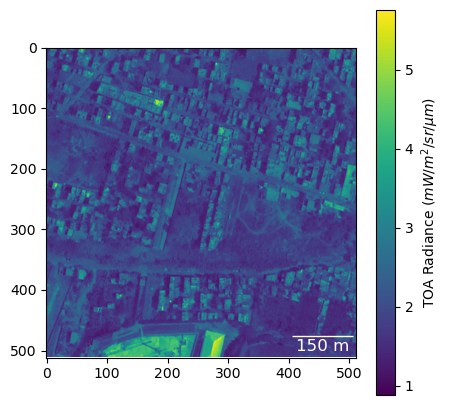

In [72]:
plot_raster_tile("rad",2, band_path, 9000,2500)

### 4. Perform the Atmoshperic Correction

#### 4.1 Obtain the Path Radiance and Gaseous transmittance for the scene from 6S obtained LOOK-UP TABLES (LUTs) 

In [49]:
import os
import glob
import pickle

ilut_path = '/home/jovyan/6S_emulator/files/iLUTs/user-defined-sensor/Continental/view_zenith_0/'
iLUTs = {} 

# Load iLUTs
filepaths = glob.glob(ilut_path + '*.ilut')
if filepaths:
    try:
        for fpath in filepaths:  
            bandName = os.path.basename(fpath).split('.')[1] 
            with open(fpath, "rb") as ilut_file:  
                iLUTs[bandName] = pickle.load(ilut_file)  
    except Exception as e:  
        print('Problem loading interpolated look up table (.ilut) files:', e)
else:
    print('Looked for iLUTs but did not find any in:\n{}'.format(ilut_path))

# See the LUT entry for each dictionary key for each band
for band_name, ilut_data in iLUTs.items():
    print(f"ILUT data for band {band_name}:")
    print(ilut_data)

ILUT data for band 650:
ILUT data for band 555:
ILUT data for band 485:
ILUT data for band 815:


#### 4.2 Obtain LUT interpolated Path Radiance and Atmospheric Gaseous transmittance (a,b) corrected for the Earth's eliptical orbit

In [50]:
import math

sun_zen = 90 - float(solar_z) # Sun Zenith angle for the scene
h2o = water(geom, scene_date) # Water Vapur for the scene
o3 = ozone(geom, scene_date) #ozone for the scene
aot = aerosol(geom, scene_date) #AOT for the scene
km = surface_elevation(geom) #Surface elevation for the scene

print(f"Scene Sun Zenith: ", sun_zen, "degrees")
print(f"Scene Water Vapour: ", h2o, "gm/cm^2")
print(f"Scene Ozone: ", o3, "cm-atm")
print(f"Scene AOT550: ", aot)
print(f"Scene elevation: ", km, "km")

bands = ['485', '555', '650', '815']
coefficients_a = {}
coefficients_b = {}

elliptical_orbit_correction = 0.03275104 * math.cos(4 / 59.66638337) + 0.96804905

for band in bands:
    ilut = iLUTs[band]
    a, b = ilut(sun_zen, h2o, o3, aot, km)
    
    # Apply elliptical orbit correction to 'a' and 'b' values
    a_corrected = a * elliptical_orbit_correction
    b_corrected = b * elliptical_orbit_correction
    
    coefficients_a[band] = a_corrected
    coefficients_b[band] = b_corrected

# Dictionary mapping old keys to new keys
key_mapping = {'485': 1, '555': 2, '650': 3, '815': 4}

# Renamed dictionary using a dictionary comprehension
coefficients_a_num = {key_mapping.get(key, key): value for key, value in coefficients_a.items()}
coefficients_b_num = {key_mapping.get(key, key): value for key, value in coefficients_b.items()}

print("Elliptical orbit corrected coefficients for a:")
print(coefficients_a_num)
print("\nElliptical orbit corrected coefficients for b:")
print(coefficients_b_num)


Scene Sun Zenith:  49.80664 degrees
Scene Water Vapour:  1.3600000381469726 gm/cm^2
Scene Ozone:  0.24335416666666668 cm-atm
Scene AOT550:  0.0989999994635582
Scene elevation:  0.9 km
Elliptical orbit corrected coefficients for a:
{1: 27.585717609320422, 2: 16.320128586619514, 3: 8.086545663888334, 4: 2.6837171028710554}

Elliptical orbit corrected coefficients for b:
{1: 309.0128140547776, 2: 319.61258570253244, 3: 288.764168863562, 4: 174.09961045064827}


#### 4.3 Method to perform atmospheric correction using interpolated a and b 

In [17]:
def get_coefficients(band_number, coefficients_dict):
    if band_number in coefficients_dict:
        return coefficients_dict[band_number]
    else:
        return None 

def Rad2Ref(band_number, band_path, output_path, LUT_a, LUT_b):
    # Open Raster of radiance
    band_ds = xr.open_dataset(f"{band_path}/B{band_number}_C3_radiance.tif", engine='rasterio', chunks={'x': 1024, 'y': 1024})
    
    #Fetch the a and b coeffcieints for the band number
    a_coeff = get_coefficients(band_number, LUT_a)
    b_coeff = get_coefficients(band_number, LUT_b)
    print(f"The a coefficient for band {band_number}: {a_coeff}")
    print(f"The b coefficient for band {band_number}: {b_coeff}")
    
    # Define L_min, L_max excluding NaN values
    band_data = band_ds.band_data.values[0]*10 #Check the consistency between radiance units of LUT instance vs TOA value
    valid_values = band_data[~np.isnan(band_data)]
    B_Lmin = np.min(valid_values)
    
    # Radiance to Reflectance conversion
    B_L = (band_data-a_coeff)/b_coeff
    
    # Coerce any value of B_L that is less than zero to zero
    B_L = np.where(B_L < 0, 0, B_L)
    
    # Create xarray DataArray
    B_xr = xr.DataArray(B_L, dims=('y', 'x'), coords={'y': band_ds.coords['y'], 'x': band_ds.coords['x']}, name=f'BAND{band_number}')
    B_xr.rio.write_crs(band_ds.rio.crs, inplace=True)
    
    # Save to raster
    B_xr.rio.to_raster(f"{output_path}/B{band_number}_C3_reflectance.tif")


#### 4.4 Atmospherically correct multispectral TOA Radiance scene band-by-band

In [18]:
for band_number in range(1, 5):
    Rad2Ref(band_number=band_number, band_path= band_path, output_path= output_path, LUT_a= coefficients_a_num, LUT_b= coefficients_b_num)


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The a coefficient for band 1: 27.585717609320422
The b coefficient for band 1: 309.0128140547776


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The a coefficient for band 2: 16.320128586619514
The b coefficient for band 2: 319.61258570253244


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The a coefficient for band 3: 8.086545663888334
The b coefficient for band 3: 288.764168863562


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The a coefficient for band 4: 2.6837171028710554
The b coefficient for band 4: 174.09961045064827


#### 4.4 Plot the atmospherically corrected BOA reflectance scene band-by-band

/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Maximum Value : 0.08266240358352661
Minimum Value : 0.0


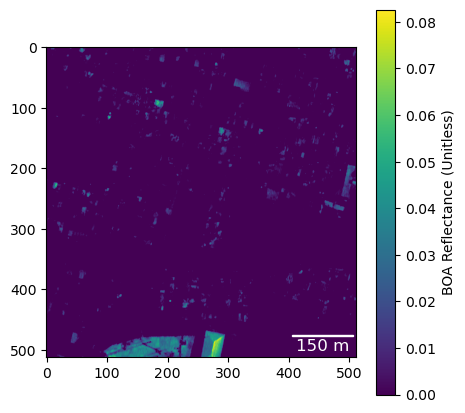

In [19]:
plot_raster_tile("ref_boa",1, band_path, 9000,2500)

#### 4.5 Stack the TOA Radiance/ BOA reflectance for all bands on disc

In [20]:
# Merge Radiance Bands 
band_numbers = [1, 2, 3, 4]

band_path = '/home/jovyan/Rasters/CARTOSAT/Bangalore'
output_path = '/home/jovyan/Rasters/CARTOSAT/Bangalore'

merge_bands("ref_boa",band_path, band_numbers, output_path)
#merge_bands("rad",band_path, band_numbers, output_path)

# Atmospheric Correction (AC) for Remotely sensed Optical imagery : Using Dark Object Subtraction

### 1. Convert TOA Radiance to TOA Reflectance

#### 1.1 Use the Satelite acquired Solar Radiance to compute Solar Irradiance at TOA

In [73]:
def calculate_irradiance(solar_radiance, distance_to_sun_au):
    """
    Calculate the solar irradiance for each band given solar radiance values
    and the distance from the sun in astronomical units.

    Parameters:
    solar_radiance (dict): Dictionary with band names as keys and radiance values as values (in mW/m²/micron/sr).
    distance_to_sun_au (float): Distance from the sun in astronomical units (AU).

    Returns:
    dict: Dictionary with band names as keys and calculated irradiance values as values (in mW/m²/micron).
    """
    irradiance_values = {}
    for band, radiance in solar_radiance.items():
        irradiance = (math.pi * radiance) / (distance_to_sun_au ** 2)
        irradiance_values[band] = irradiance
    
    return irradiance_values

solar_radiance = {
    'B1': float(variables_dict.get('B1SolarRadiance')),
    'B2': float(variables_dict.get('B2SolarRadiance')),
    'B3': float(variables_dict.get('B3SolarRadiance')),
    'B4': float(variables_dict.get('B4SolarRadiance'))
}

distance_to_sun_au = 1.0
irradiance_values = calculate_irradiance(solar_radiance, distance_to_sun_au)
irradiance_values = solar_radiance
print(irradiance_values)

import math
from datetime import datetime

def rad_to_toa(bandname, rad, irradiance_values, solar_z, scene_date):
    """
    Converts at-sensor radiance to top of atmosphere reflectance.

    Parameters:
    bandname (str): The name of the band.
    rad (float): The at-sensor radiance.
    irradiance_values (dict): Dictionary with band names as keys and solar exoatmospheric spectral irradiance values as values.
    solar_z (float): The solar zenith angle in degrees.
    scene_date (datetime): The date of the scene.

    Returns:
    float: Top of atmosphere reflectance.
    """

    # Solar exoatmospheric spectral irradiance
    ESUN = irradiance_values[bandname]

    #print(ESUN)

    # Solar angle correction
    solar_angle_correction = math.cos(math.radians(90 - float(solar_z)))

    # Earth-Sun distance (from day of year)
    doy = scene_date.timetuple().tm_yday
    #print(doy)
    d = 1 - 0.01672 * math.cos(0.9856 * (doy - 4))  # http://physics.stackexchange.com/questions/177949/earth-sun-distance-on-a-given-day-of-the-year
    #print(d)

    # Conversion factor
    multiplier = ESUN * solar_angle_correction / (math.pi * d ** 2)

    # Top of atmosphere reflectance
    toa_reflectance = rad / multiplier

    return toa_reflectance

# # Extracted radiance value
# radiance_values = {
#     'B1': 1.854519,
#     'B2': 1.431070,
#     'B3': 1.147435,
#     'B4': 1.421886
# } # Replace with actual radiance value
# solar_zenith_angle = float(sun_zen)  # Example solar zenith angle in degrees

# # Calculate TOA reflectance for band 'B1'
# toa_reflectance = rad_to_toa('B4', radiance_value, irradiance_values, solar_zenith_angle, scene_date)
# print(f"TOA Reflectance for band 'B1': {toa_reflectance}")

# toa_values = {}
# for band, radiance in radiance_values.items():
#         toa_reflectance = rad_to_toa(band, radiance, irradiance_values, solar_zenith_angle, scene_date)
#         toa_values[band] = toa_reflectance
# print(toa_values)

{'B1': 196.78, 'B2': 182.01, 'B3': 157.54, 'B4': 110.86}


#### 1.2 Simulate Downwelling Irradiance for the scene (validation of computed irradiance from Sensor acquired Radiance)

Results:
B1: 111.20819999999999
B2: 107.6324
B3: 96.28110000000001
B4: 67.8881
[111.20819999999999, 107.6324, 96.28110000000001, 67.8881]
[196.78, 182.01, 157.54, 110.86]


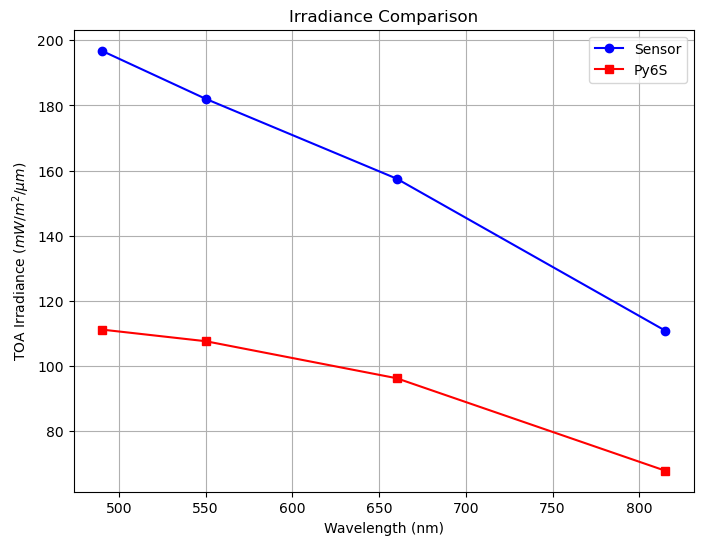

In [74]:
def spectralResponseFunction(bandname):
    """
    Extract spectral response function for given band name
    """
    bandSelect = {
        'B1':Wavelength(0.45, 0.52),
        'B2':Wavelength(0.52, 0.59),
        'B3':Wavelength(0.62, 0.68),
        'B4':Wavelength(0.77, 0.86)
        }
    return bandSelect[bandname]

spectralResponseFunction('B1')

# Instantiate
s = SixS()

# Atmospheric constituents
s.atmos_profile = AtmosProfile.UserWaterAndOzone(h2o,o3)
s.aero_profile = AeroProfile.Continental
s.aot550 = aot

# Earth-Sun-satellite geometry
s.geometry = Geometry.User()
s.geometry.view_z = 0               # always NADIR (I think..)
s.geometry.solar_z = float(sun_zen)      # solar zenith angle
s.geometry.month = float(scene_date.month) # month and day used for Earth-Sun distance
s.geometry.day = float(scene_date.day )    # month and day used for Earth-Sun distance
s.altitudes.set_sensor_satellite_level()
s.altitudes.set_target_custom_altitude(float(km))
s.ground_reflectance = GroundReflectance.HomogeneousLambertian(0)


# Simulate Irradiance
bands = ['B1', 'B2', 'B3', 'B4']
results = {}
for band in bands:
    # Set wavelength for the band
    s.wavelength = spectralResponseFunction(band)
    # Run 6S
    s.run()
    # Extract outputs
    Edir = s.outputs.direct_solar_irradiance
    Edif = s.outputs.diffuse_solar_irradiance

    # Store results
    results[band] = (Edir + Edif)/10

# Print or use results as needed
print("Results:")
for band, result in results.items():
    print(f"{band}: {result}")

# Plotting the irradiance values
wavelengths = {
    'B1': 490, #Cartosat-3 wavelength centres
    'B2': 550,
    'B3': 660,
    'B4': 815
}
wavelengths_list = [wavelengths[band] for band in solar_radiance.keys()]
irradiance_list = [irradiance_values[band] for band in solar_radiance.keys()]
result_list = [results[band] for band in solar_radiance.keys()]
print(result_list)
print(irradiance_list)

# Plotting
plt.figure(figsize=(8, 6))


plt.plot(wavelengths_list, irradiance_list, marker='o', linestyle='-', color='b', label='Sensor')
plt.plot(wavelengths_list, result_list, marker='s', linestyle='-', color='r', label='Py6S')

plt.title('Irradiance Comparison')
plt.xlabel('Wavelength (nm)')
plt.ylabel('TOA Irradiance ($m W/ m^2/\mu m$)')
plt.grid(True)
plt.legend()
plt.show()

#### 1.3 Obtain TOA reflectance for the Satelite image band by band 

In [77]:
def get_irradiance(band_number, irradiance_dict):
    if band_number in irradiance_dict:
        return irradiance_dict[band_number]
    else:
        return None 

def Rad2TOA_Ref(band_number, band_path, output_path, irradiance_val, solar_zenith_angle, scene_date):
    # Open Raster of radiance
    band_ds = xr.open_dataset(f"{band_path}/{band_number}_C3_radiance.tif", engine='rasterio',chunks={'x': 1024, 'y': 1024})
    
    #Fetch TOA irradiance for the band number
    irrad = get_irradiance(band_number, irradiance_val)
    print(f"The TOA irradiance for band {band_number}: {irrad}")
    
    # Define L_min, L_max excluding NaN values
    band_data = band_ds.band_data.values[0]
    valid_values = band_data[~np.isnan(band_data)]
    B_Lmin = np.min(valid_values)
    
    # Radiance to Reflectance conversion
    B_L = rad_to_toa(band_number, band_data, irradiance_values, solar_zenith_angle, scene_date)
    
    # Create xarray DataArray
    B_xr = xr.DataArray(B_L, dims=('y', 'x'), coords={'y': band_ds.coords['y'], 'x': band_ds.coords['x']}, name=f'BAND{band_number}')
    B_xr.rio.write_crs(band_ds.rio.crs, inplace=True)
    
    # Save to raster
    B_xr.rio.to_raster(f"{output_path}/{band_number}_C3_TOA_reflectance.tif")
    
for band_number in range(1, 5):
    band_name = f'B{band_number}'
    Rad2TOA_Ref(band_name, band_path, output_path, irradiance_values, sun_zen, scene_date)


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The TOA irradiance for band B1: 196.78


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The TOA irradiance for band B2: 182.01


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The TOA irradiance for band B3: 157.54


/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


The TOA irradiance for band B4: 110.86


#### 1.4 Plot the TOA reflectance

/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Maximum Value : 0.10802951455116272
Minimum Value : 0.023440366610884666


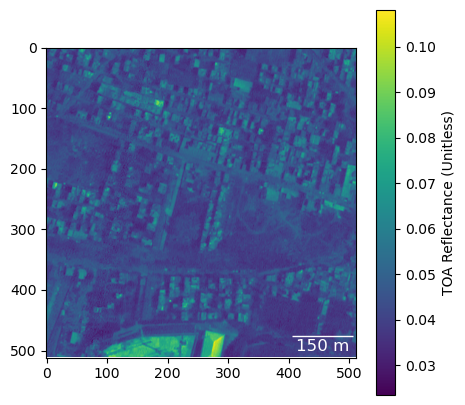

In [78]:
plot_raster_tile("ref_toa",1, band_path, 9000,2500)

#### 1.5 Perform the Dark Object Subtraction band by band

In [21]:
%%bash
python '/home/jovyan/6S_emulator/DOS_v2.py' '/home/jovyan/Rasters/CARTOSAT/Bangalore/B4_C3_TOA_reflectance.tif'  '/home/jovyan/Rasters/CARTOSAT/Bangalore/B3_C3_TOA_reflectance.tif' '/home/jovyan/Rasters/CARTOSAT/Bangalore/B2_C3_TOA_reflectance.tif' '/home/jovyan/Rasters/CARTOSAT/Bangalore/B1_C3_TOA_reflectance.tif' 
-o '/home/jovyan/Rasters/CARTOSAT/Bangalore/' --model -3

#### 1.6 Plot the BOA Dos reflectance

/opt/conda/lib/python3.10/site-packages/xarray/core/dataset.py:278: UserWarning: The specified chunks separate the stored chunks along dimension "x" starting at index 1024. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Maximum Value : 0.10687248408794403
Minimum Value : 0.022283334285020828


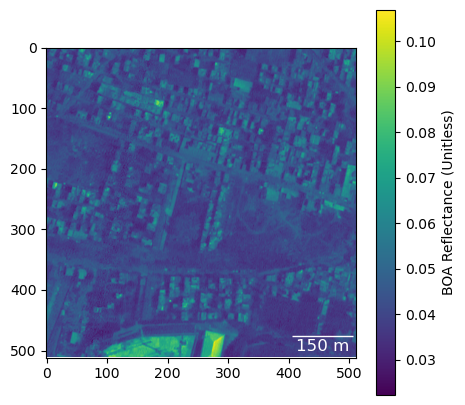

In [22]:
plot_raster_tile("ref_dos",1, band_path, 9000,2500)

#### 1.5 Stack the TOA reflectance/ BOA DOS reflectance

In [44]:
#merge_bands("ref_toa",band_path, band_numbers, output_path)
#merge_bands("ref_dos",band_path, band_numbers, output_path)

#### 1.6 Compare the spectral profiles of different TOA/BOA products for the scene

[<xarray.DataArray (band: 1, y: 19059, x: 18590)>
dask.array<open_rasterio-a1c9f065e64dba1d96fd71a0b23ab456<this-array>, shape=(1, 19059, 18590), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.705e+05 7.705e+05 7.705e+05 ... 7.91e+05 7.91e+05
  * y            (y) float64 1.457e+06 1.457e+06 ... 1.436e+06 1.436e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      BAND1, <xarray.DataArray (band: 1, y: 19059, x: 18590)>
dask.array<open_rasterio-c6b00fae8d8cf50d05f2705290980a94<this-array>, shape=(1, 19059, 18590), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.705e+05 7.705e+05 7.705e+05 ... 7.91e+05 7.91e+05
  * y            (y) float64 1.457e+06 1.457e+06 ... 1.436e+06 1.436e+06
    spatial_ref  int64 0
Attributes:
   

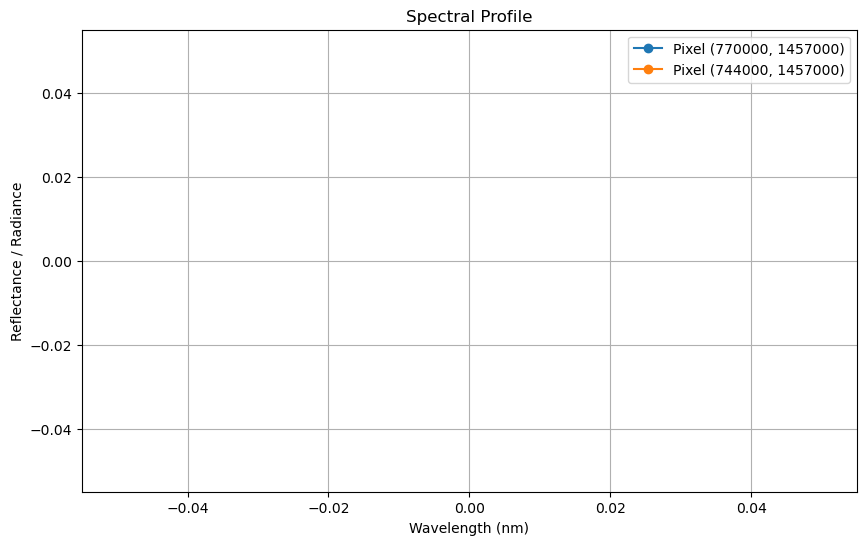

In [46]:
import matplotlib.pyplot as plt

def plot_spectral_profile(band_path, band_numbers, wavelengths, pixel_coords, mode):
    """
    Plots the spectral profile of specified pixels from individual band images.

    Parameters:
    band_path (str): Base path to the band images.
    band_numbers (list): List of band numbers.
    wavelengths (list): List of wavelengths corresponding to each band.
    pixel_coords (list): List of (x, y) tuples specifying the pixel coordinates.
    mode (str): Mode to specify the type of bands ('rad', 'ref_boa', 'ref_toa', 'ref_dos').
    """
    # Define band paths based on the mode
    if mode == "rad":
        band_paths = [f"{band_path}/B{band_number}_C3_radiance.tif" for band_number in band_numbers]
    elif mode == "ref_boa":
        band_paths = [f"{band_path}/B{band_number}_C3_reflectance.tif" for band_number in band_numbers]
    elif mode == "ref_toa":
        band_paths = [f"{band_path}/B{band_number}_C3_TOA_reflectance.tif" for band_number in band_numbers]
    elif mode == "ref_dos":
        band_paths = [f"{band_path}/B{band_number}_C3_BOA_DOS.tif" for band_number in band_numbers]
    else:
        raise ValueError("Invalid mode or output_path not provided.")
    
    # Open bands
    bands = [rxr.open_rasterio(band_path, chunks={'x': 1024, 'y': 1024}) for band_path in band_paths]
    #bands = [xr.open_dataset(band_paths, engine='rasterio', chunks={'x': 1024, 'y': 1024}) for band_path in band_paths]

    print(bands)

    # Plot spectral profiles for each pixel
    plt.figure(figsize=(10, 6))
    for (x, y) in pixel_coords:
        #print(f"Pixel coordinates: ({x}, {y})")  # Debug print
        print([band.sel(x=x, y=y, method='nearest').values for band in bands])
        #img_data = bands.band_data.values[:].astype(np.float32)[:, x:x+0, y:y+0]
        #print(img_data)
        spectral_values = [band.sel(x=x, y=y, method='nearest').data.flatten()[0] for band in bands]
        #print(f"Spectral values for pixel ({x}, {y}):", spectral_values)  # Debug print
        
        plt.plot(wavelengths, spectral_values, marker='o', label=f'Pixel ({x}, {y})')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance / Radiance')
    plt.title('Spectral Profile')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
pixel_coords = [(770000, 1457000), (744000, 1457000)]  # Example pixel coordinates
wavelength_c3 = [485, 550, 650, 815]  # Adjust these wavelengths according to your data
band_path = "/home/jovyan/Rasters/CARTOSAT/Bangalore"  # Replace with your band path
band_numbers = [1, 2, 3, 4]
mode = "ref_boa"  # Change as needed

plot_spectral_profile(band_path, band_numbers, wavelength_c3, pixel_coords, mode)




# def extract_spectral_values(band_path, band_numbers, pixel_coords, mode):
#     """
#     Extracts spectral values for a single pixel from individual band images.

#     Parameters:
#     band_path (str): Base path to the band images.
#     band_numbers (list): List of band numbers.
#     pixel_coords (tuple): Pixel coordinates (x, y) to extract values from.
#     mode (str): Mode to specify the type of bands ('rad', 'ref_boa', 'ref_toa', 'ref_dos').

#     Returns:
#     dict: Dictionary with band paths as keys and spectral values as values.
#     """
#     # Define band paths based on the mode
#     if mode == "rad":
#         band_paths = [f"{band_path}/B{band_number}_C3_radiance.tif" for band_number in band_numbers]
#     elif mode == "ref_boa":
#         band_paths = [f"{band_path}/B{band_number}_C3_reflectance.tif" for band_number in band_numbers]
#     elif mode == "ref_toa":
#         band_paths = [f"{band_path}/B{band_number}_C3_TOA_reflectance.tif" for band_number in band_numbers]
#     elif mode == "ref_dos":
#         band_paths = [f"{band_path}/B{band_number}_C3_BOA_DOS.tif" for band_number in band_numbers]
#     else:
#         raise ValueError("Invalid mode or output_path not provided.")
    
#     # Open bands
#     bands = [rxr.open_rasterio(band_path, chunks={'x': 1024, 'y': 1024}) for band_path in band_paths]

#     # Extract spectral values for the given pixel coordinates
#     spectral_values = {}
#     for band_path, band_ds in zip(band_paths, bands):
#         value = band_ds.sel(x=pixel_coords[0], y=pixel_coords[1], method='nearest').values.item()
#         spectral_values[band_path] = value

#     return spectral_values

# # Example usage
# pixel_coords = (8000, 2500)  # Replace with your pixel coordinates
# #band_path = "path/to/bands"
# band_numbers = [1, 2, 3, 4]
# mode = "rad"  # Change as needed

# spectral_values = extract_spectral_values(band_path, band_numbers, pixel_coords, mode)
# print(f"Spectral values for pixel at {pixel_coords}: {spectral_values}")

# band_path
